In [1]:
import os

os.chdir("..")

In [2]:
import torch
from diffusers import FluxKontextPipeline
from PIL import Image
import helpers.drawing as drawing
import numpy as np
import cv2
import shutil
from rembg import remove
import io

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
# !export HF_HUB_CACHE=./cache

## Normal FluxKontext Generation

In [5]:
pipe = FluxKontextPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-Kontext-dev", torch_dtype=torch.bfloat16
)
pipe = pipe.to("cuda")


Loading pipeline components...: 100%|█████████████████████████████████████████| 7/7 [00:00<00:00,  7.14it/s]


## Extract the subject/character

In [6]:

def generate_image(base_scene_path, save_path, prompt = "Add character to the image.", width=None, height=None):
    if isinstance(base_scene_path, str):
        base_scene = Image.open(base_scene_path).convert("RGB")
    else:
        base_scene = base_scene_path.convert("RGB")

    if width is None:
        width, height = base_scene.size

    seed = torch.Generator().manual_seed(42)

    result_img_base = pipe(
        prompt=prompt,
        image=base_scene,
        num_inference_steps=28,
        height=height,
        width=width,
        # generator=seed,
        _auto_resize=False,
        max_area=width*height
    ).images[0]
    result_img_base.save(save_path)
    return result_img_base

100%|███████████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00,  1.23s/it]


In [3]:
def remove_background(
    image: Image.Image,
    cropped: bool = True,
    padding: int = 10
) -> Image.Image:
    """Remove background and optionally crop to content."""
    # Convert the PIL image to bytes
    buffer = io.BytesIO()
    image.save(buffer, format="PNG")
    
    # Remove background
    output_bytes = remove(buffer.getvalue())
    output_image = Image.open(io.BytesIO(output_bytes)).convert("RGBA")
    
    if cropped:
        # Crop to content with padding
        alpha = output_image.split()[3]
        bbox = alpha.getbbox()
        if bbox:
            left, upper, right, lower = bbox
            width, height = output_image.size

            # Apply padding within bounds
            left = max(0, left - padding)
            upper = max(0, upper - padding)
            right = min(width, right + padding)
            lower = min(height, lower + padding)

            output_image = output_image.crop((left, upper, right, lower))
    
    return output_image


In [11]:
src = "custom_data/real_product"

end_dir = os.path.join(src, "original")
image_extensions = (".png", ".jpg", ".jpeg", ".webp")
image_paths = [
    os.path.join(end_dir, fname)
    for fname in os.listdir(end_dir)
    if fname.lower().endswith(image_extensions)
]
image_paths.sort()

# Create end, reference and start folders, if it doesnot exists
os.makedirs(os.path.join(src, "end"), exist_ok=True)
os.makedirs(os.path.join(src, "reference"), exist_ok=True)
os.makedirs(os.path.join(src, "start"), exist_ok=True)

len(image_paths)

45

In [4]:

# Rename all images in end_dir as 000.<ext>, 001.<ext>, etc.
for idx, old_path in enumerate(sorted(image_paths)):
    ext = os.path.splitext(old_path)[1].lower()
    new_name = f"{idx:03d}{ext}"
    new_path = os.path.join(end_dir, new_name)
    shutil.move(old_path, new_path)

# Update image_paths to reflect new names
image_paths = [
    os.path.join(end_dir, fname)
    for fname in sorted(os.listdir(end_dir))
    if fname.lower().endswith(image_extensions)
]

In [5]:
src_dir = "custom_data/real_product/products"
# List all directories in src_dir
dir_list = [d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]
dir_list.sort()


# For each directory, list all images (with full path)
images_in_dirs = []
image_extensions = (".png", ".jpg", ".jpeg", ".webp")
for d in dir_list:
    dir_path = os.path.join(src_dir, d)
    images = [
        os.path.join(dir_path, fname)
        for fname in sorted(os.listdir(dir_path))
        if fname.lower().endswith(image_extensions)
    ]
    images_in_dirs.append(images)

# images_in_dirs is a double dimension list: [[img1, img2, ...], [img1, ...], ...]


In [218]:
i = 49
dir_images = images_in_dirs[i]
len(dir_images)

IndexError: list index out of range

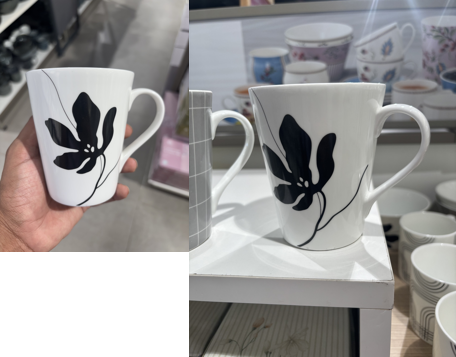

In [213]:
# Preview images

img0 = Image.open(dir_images[0])
img0 = img0.resize((img0.width//16, img0.height//16))

img1 = Image.open(dir_images[1])
img1 = img1.resize((img1.width//16, img1.height//16))

stitched_img = Image.new("RGBA", (img0.width + img1.width, max(img0.height, img1.height)))
stitched_img.paste(img0, (0, 0))
stitched_img.paste(img1, (img0.width, 0))

stitched_img

In [214]:
# Remove bag and save the image
target = f"{src}/original/{i:03d}.png"
o = 0
r = 1

original_img = Image.open(dir_images[o])

drawing.crop_image(dir_images[r], target.replace("original", "reference"), True)


Canvas(height=512, image_data=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x80\x00\x00\x02\x00\x08\x06\x0…

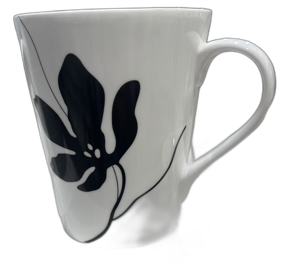

In [215]:
ref_img = remove_background(drawing.processed_image)

ref_img.resize((ref_img.width//2, ref_img.height//2))

In [216]:
original_img.save(target)
ref_img.save(target.replace("original", "reference"))


In [4]:
i=-1

In [51]:
i = i+1
drawing.crop_image(image_paths[i], image_paths[i].replace("original", "end"))


IndexError: list index out of range

In [20]:
end_dir = os.path.join(src, "end")
image_extensions = (".png", ".jpg", ".jpeg", ".webp")
image_paths = [
    os.path.join(end_dir, fname)
    for fname in os.listdir(end_dir)
    if fname.lower().endswith(image_extensions)
]



In [ ]:
i = 0
image_path = image_paths[i]
end = Image.open(image_path)
end.resize((256, 256))

In [ ]:

reference_prompt = "Extract the boy from the image, in a white background."

reference_save_path = image_path.replace("end", "reference")
reference = generate_image(image_path, reference_save_path, reference_prompt, 512, 512)

In [ ]:
reference_prompt = "rotate the cup"

generate_image(reference, reference_save_path, reference_prompt)

In [ ]:
start_prompt = "Remove the boy from the image."

start_save_path = image_path.replace("end", "start")
start = generate_image(image_path, start_save_path, start_prompt)
start

In [ ]:
print(end.size, start.size)

In [ ]:


# Ensure both images are the same size and mode
if start.size != end.size or start.mode != end.mode:
    end_resized = end.resize(start.size).convert(start.mode)
else:
    end_resized = end

# Convert to numpy arrays
start_np = np.array(start)
end_np = np.array(end_resized)

# Compute absolute pixel-wise difference
diff_np = np.abs(start_np.astype(np.int16) - end_np.astype(np.int16)).astype(np.uint8)

# Convert back to PIL Image
diff_img = Image.fromarray(diff_np)

# Optionally display or save the difference image
diff_img.resize((diff_img.size[0]//3, diff_img.size[1]//3))


In [ ]:
import zipfile
import os

def zip_src_folder(src, zip_path):
    """
    Create a zip archive from the folder specified by src.

    Args:
        src (str): Path to the source directory to zip.
        zip_path (str): Path to the output zip file.
    """
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(src):
            for file in files:
                file_path = os.path.join(root, file)
                # Write file to zip, preserving folder structure relative to src
                arcname = os.path.relpath(file_path, start=src)
                zipf.write(file_path, arcname=arcname)

# Example usage:
# src = "path/to/source_folder"
# zip_path = "output.zip"
# zip_src_folder(src, zip_path)



In [4]:
# Merge data from two folders, ensuring the faithfulness of the dataset
srcs = ['custom_data/product', 'custom_data/real_product']
target = ['custom_data/mixed_product']

i = 0

for src in srcs:
    end_dir = os.path.join(src, 'end')
    start_dir = os.path.join(src, 'start')
    reference_dir = os.path.join(src, 'reference')
    if not os.path.exists(end_dir):
        continue
    for fname in os.listdir(end_dir):
        end_path = os.path.join(end_dir, fname)
        start_path = os.path.join(start_dir, fname)
        reference_path = os.path.join(reference_dir, fname)
        if os.path.isfile(end_path) and os.path.isfile(start_path) and os.path.isfile(reference_path):
            ext = os.path.splitext(fname)[1]
            new_fname = f"{i:03}{ext}"
            for subfolder, src_path in zip(['end', 'start', 'reference'], [end_path, start_path, reference_path]):
                tgt_subdir = os.path.join(target[0], subfolder)
                os.makedirs(tgt_subdir, exist_ok=True)
                tgt_path = os.path.join(tgt_subdir, new_fname)
                shutil.copy2(src_path, tgt_path)
            i += 1

